In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import pandas as pd

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

In [2]:
# Import data and create DataFrame of data to augment
X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

knn_5 = pd.read_csv('../outputs/results/knn_5.csv')['0']
ind_5 = knn_5.sort_values(ascending=True).index
X_worst = X_train[ind_5[:(len(X_train) // 10)]]
y_worst = y_train[ind_5[:(len(X_train) // 10)]]

X_worst_df = pd.DataFrame(X_worst)
X_worst_df['target'] = y_worst

# Infer metadata: categorical and numeric features
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(X_worst_df)

In [3]:
synthesizer = CTGANSynthesizer.load(
    filepath='../outputs/synthesizers/best_ctgan.pkl'
)

losses = synthesizer.get_loss_values()

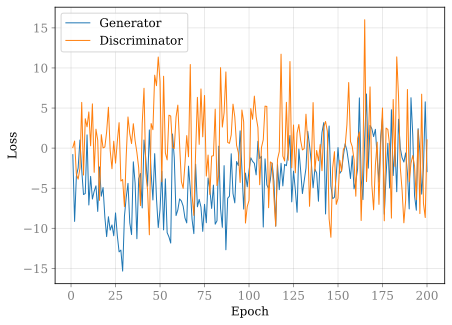

In [4]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(1, 201), losses['Generator Loss'], lw=1, label='Generator')
ax.plot(range(1, 201), losses['Discriminator Loss'], lw=1, label='Discriminator')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
fig.savefig('../outputs/figures/gen_disc_losses.pdf', dpi=300, bbox_inches='tight')

In [5]:
from sdv.evaluation.single_table import evaluate_quality

synthetic_data = synthesizer.sample(num_rows=len(X_worst_df)) # 100% oversampling

In [6]:
X_worst_df.columns = [str(c) for c in X_worst_df.columns]
synthetic_data.columns = [str(c) for c in synthetic_data.columns]
#quality_report = evaluate_quality(X_worst_df, synthetic_data, metadata)

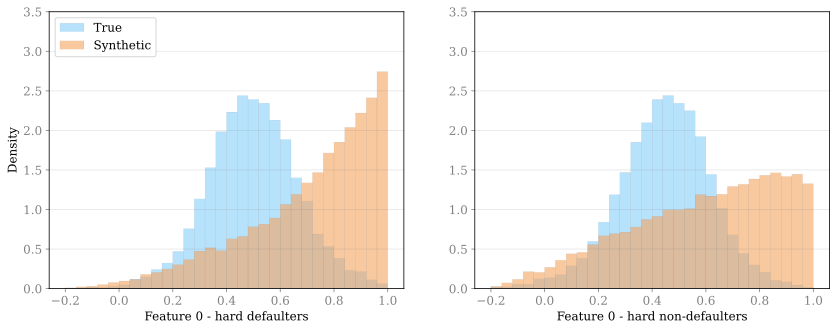

In [7]:
true_def_0 = X_worst_df['0'][X_worst_df['target'] == 1]
synth_def_0 = synthetic_data['0'][synthetic_data['target'] == 1]

true_nondef_0 = X_worst_df['0'][X_worst_df['target'] == 0]
synth_nondef_0 = synthetic_data['0'][synthetic_data['target'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Feature 0
min_v, max_v = -0.2, 1
bin_width = (max_v - min_v) / 30
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0].hist(true_def_0.values, bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True, label='True')
axes[0].hist(synth_def_0.values, bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True, label='Synthetic')
axes[0].set_xlabel('Feature 0 - hard defaulters')
axes[0].set_ylabel('Density')
axes[0].grid(axis='x')
axes[0].legend(loc='upper left')
axes[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

axes[1].hist(true_nondef_0.values, bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True)
axes[1].hist(synth_nondef_0.values, bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True)
axes[1].set_xlabel('Feature 0 - hard non-defaulters')
axes[1].grid(axis='x')
axes[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

fig.savefig('../outputs/figures/true_vs_synth_hist.pdf', dpi=300, bbox_inches='tight')